## U-Net 

Application to colorization

In [22]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
import torch.utils as utils

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [23]:
# Read CIFAR-10 data and convert each image to grayscale for input
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, path, transform1 = None, transform2 = None, train = True):
        self.transform1 = torchvision.transforms.ToTensor()
        self.transform2 = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])
        self.train = train

        self.labelset = torchvision.datasets.CIFAR10(root = path, train = self.train, download = True)
        self.dataset = torchvision.datasets.CIFAR10(root = path, train = self.train, download = True)

        self.datanum = len(self.dataset)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_label = self.labelset[idx][0]
        out_data = self.dataset[idx][0]

        if self.transform1:
            out_label = self.transform1(out_label)

        if self.transform2:
            out_data = self.transform2(out_data)

        return out_data, out_label

In [24]:
# Load Data
dataset = Mydatasets('./data', train=True)
print(dataset[0][0].shape)
print(dataset[0][1].shape)

batch_size = 200

dataloader_train = utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([1, 32, 32])
torch.Size([3, 32, 32])


In [25]:
# Network

import torch.nn as nn

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
    )
    self.deconv1 = nn.Sequential(
        nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
        nn.ReLU(),
    )
    self.deconv2 =nn.Sequential(
        nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
    )

  def forward(self, x1):
    x2 = self.conv1(x1)
    x3 = self.conv2(x2)
    x4 = self.deconv1(x3)
    x5 = torch.cat((x4, x2), dim=1)
    y  = self.deconv2(x5)
    return y

In [26]:
# Define model
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [27]:
# Training
nepoch = 300

for i in range(nepoch):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    model.zero_grad()
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    y = model(x)
    loss = criterion(y, t)
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")


EPOCH: 1
  train loss: 0.016173368848860264
EPOCH: 2
  train loss: 0.010864101607352496
EPOCH: 3
  train loss: 0.009764429453760385
EPOCH: 4
  train loss: 0.009190293123945594
EPOCH: 5
  train loss: 0.008778743403032422
EPOCH: 6
  train loss: 0.008383033838123083
EPOCH: 7
  train loss: 0.007989245004951954
EPOCH: 8
  train loss: 0.007617270950227976
EPOCH: 9
  train loss: 0.00728506594337523
EPOCH: 10
  train loss: 0.007021178387105465
EPOCH: 11
  train loss: 0.006830611595883966
EPOCH: 12
  train loss: 0.006709890173748135
EPOCH: 13
  train loss: 0.006607940623536706
EPOCH: 14
  train loss: 0.006538413504138589
EPOCH: 15
  train loss: 0.006455201474949717
EPOCH: 16
  train loss: 0.006419657437130809
EPOCH: 17
  train loss: 0.006349886041134596
EPOCH: 18
  train loss: 0.00630942689627409
EPOCH: 19
  train loss: 0.006296385729685426
EPOCH: 20
  train loss: 0.006268495311960578
EPOCH: 21
  train loss: 0.006265820784494281
EPOCH: 22
  train loss: 0.00625733095780015
EPOCH: 23
  train loss

(32, 32, 3)


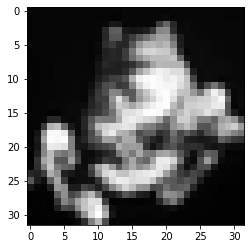

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


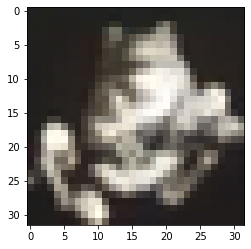

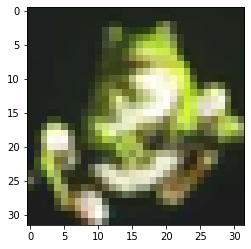


(32, 32, 3)


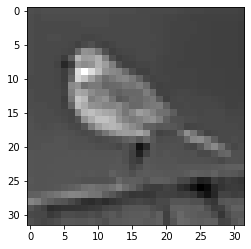

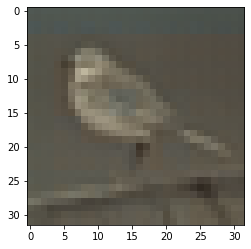

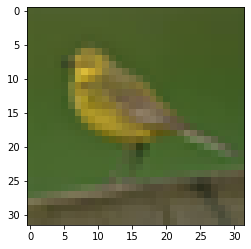


(32, 32, 3)


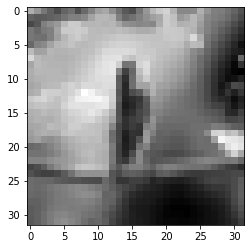

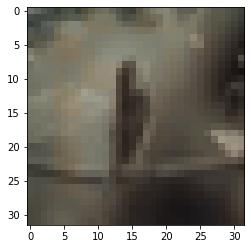

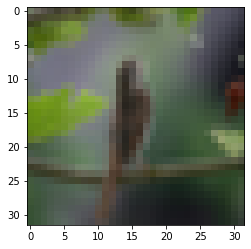


(32, 32, 3)


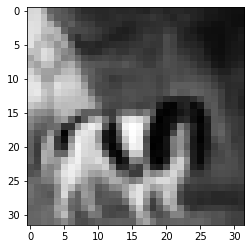

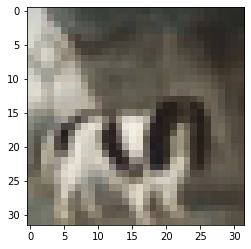

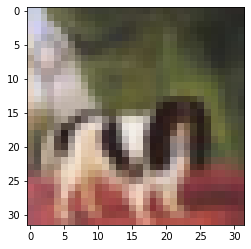


(32, 32, 3)


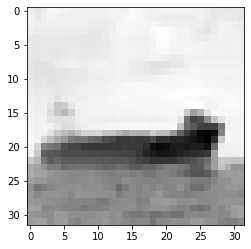

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


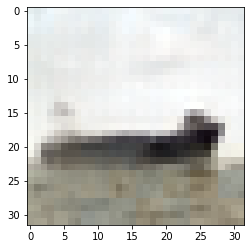

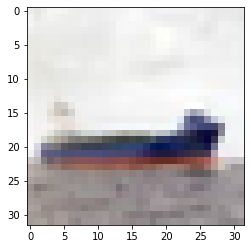


(32, 32, 3)


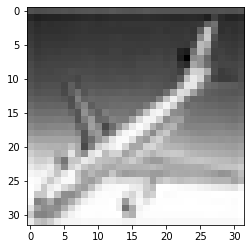

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


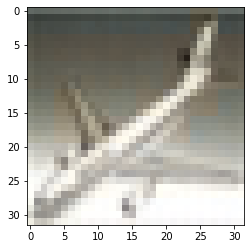

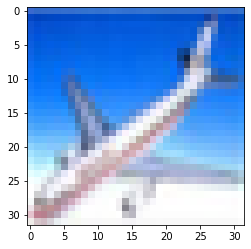


(32, 32, 3)


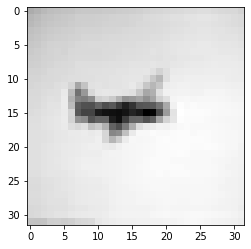

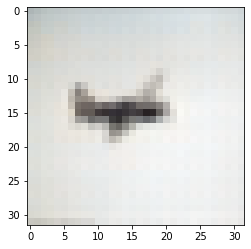

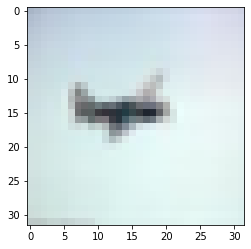


(32, 32, 3)


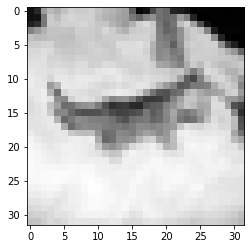

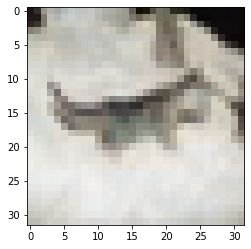

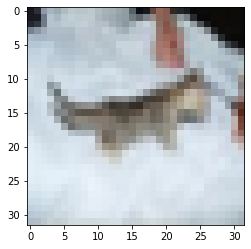


(32, 32, 3)


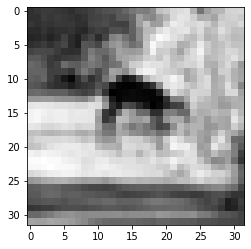

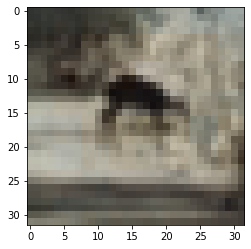

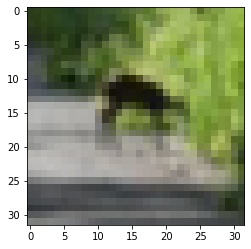


(32, 32, 3)


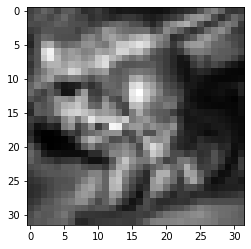

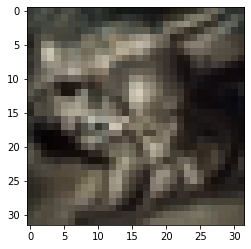

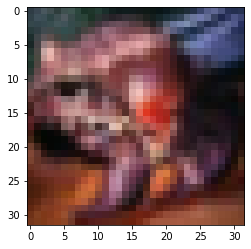

In [29]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    x, t = iter(dataloader_train).next()
    x = x.to(device)
    y = model(x)
    y = y[0].cpu().permute(1,2,0).detach().numpy()
    print(y.shape)
    x = np.reshape(x[0].cpu().detach().numpy(), [32, 32])
    #y = np.reshape(y[0].cpu().detach().numpy(), [3, 32, 32])
    t = t[0].cpu().permute(1,2,0).detach().numpy()
    
    plt.imshow(x, cmap='gray')
    plt.savefig("unet_colorize_gray{i:}".format(i=i))
    plt.show()
    plt.imshow(y)
    plt.savefig("unet_colorize_est{i:}".format(i=i))
    plt.show()
    plt.imshow(t)
    plt.savefig("unet_colorize_orig{i:}".format(i=i))
    plt.show()
    print("\n =================== ")